In [1]:
import gensim.parsing.preprocessing as gsp
from gensim import utils
import json
import requests
from pprint import pprint
import gensim.corpora as corpora
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import nltk
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
import mysql.connector
import datetime
import time
from nltk.collocations import *
from nltk.tokenize import regexp
import json
from nltk import tokenize
import numpy as np
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# data preprocessing

In [69]:
# nltk.download('stopwords')
filters = [gsp.strip_tags, 
#            gsp.strip_punctuation, 
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric, 
           gsp.remove_stopwords, 
           gsp.strip_short]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

stop_words = ['sen', 'senator', 'senate', 'senators']

url_docs = requests.get("http://das-lab.org:1701/docs")
text_docs = url_docs.text
json_data_docs = json.loads(text_docs)

unprocessed_data = [o['doc_text'] for o in json_data_docs]
doc_ids = [o['doc_id'] for o in json_data_docs]
data = [clean_text(text) for text in unprocessed_data]

for i in range(len(data)):
    text_tokens = tokenize.word_tokenize(data[i])
    tokens = [word for word in text_tokens if not word in stop_words and len(word) > 1]
    data[i] = " ".join(tokens)

# lda preprocessing
tokenizer = regexp.RegexpTokenizer(r"\w+")
tokens = [tokenizer.tokenize(doc) for doc in data]

tokens = [tuple(doc) for doc in tokens]
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

# create lda mallet model

In [73]:
path_to_mallet_binary = "/Users/chasemattingly/mallet-2.0.6/bin/mallet"
# model = LdaMallet(path_to_mallet_binary, corpus=corpus,
#                   num_topics=10, id2word=id2word)

# compute coherence values vs num topics

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [75]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=50)

100%|██████████| 9/9 [09:41<00:00, 64.59s/it]


In [88]:
model = model_list[4]

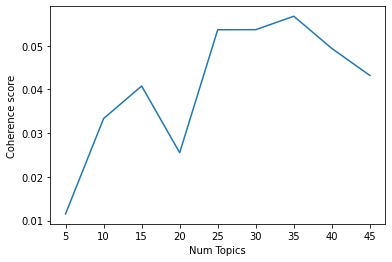

In [76]:
plt.plot(range(5,50, 5), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [89]:
model.print_topics()

[(24,
  '0.019*"senators" + 0.009*"tammy" + 0.009*"letter" + 0.009*"chris" + 0.008*"bennet" + 0.008*"calif" + 0.007*"mass" + 0.007*"kaine" + 0.007*"menendez" + 0.007*"md"'),
 (16,
  '0.019*"biden" + 0.016*"rule" + 0.016*"vaccine" + 0.015*"daines" + 0.013*"marshall" + 0.013*"mandate" + 0.013*"administration" + 0.012*"irs" + 0.009*"braun" + 0.008*"human"'),
 (23,
  '0.024*"united" + 0.024*"states" + 0.022*"china" + 0.016*"world" + 0.016*"global" + 0.013*"american" + 0.013*"foreign" + 0.012*"manufacturing" + 0.012*"international" + 0.012*"security"'),
 (22,
  '0.025*"education" + 0.022*"students" + 0.020*"school" + 0.019*"support" + 0.016*"community" + 0.016*"families" + 0.014*"high" + 0.014*"maine" + 0.014*"workforce" + 0.013*"children"'),
 (13,
  '0.020*"law" + 0.014*"violence" + 0.013*"children" + 0.013*"safety" + 0.012*"enforcement" + 0.012*"child" + 0.011*"sexual" + 0.010*"justice" + 0.009*"safe" + 0.009*"survivors"'),
 (10,
  '0.021*"defense" + 0.017*"water" + 0.015*"funding" + 0.01

# post topics

In [14]:
req = requests.post("http://das-lab.org:1701/topics", json=dict(model.print_topics()))

# get topic ids for doc_top_matrix

In [15]:
url_topics = requests.get("http://das-lab.org:1701/topics")
text_topics = url_topics.text
json_data_topics = json.loads(text_topics)

In [16]:
topic_ids = [o['topic_id'] for o in json_data_topics]

# compute doc_top_matrix

In [86]:
doc_top_matrix = [*model.load_document_topics()]

In [87]:
doc_top_matrix[0]

[(15, 0.44660192977600877),
 (29, 0.1553398081399862),
 (14, 0.0873786439413874),
 (11, 0.0873786439413874),
 (34, 0.029126214026247415),
 (28, 0.029126214026247415),
 (5, 0.029126214026247415),
 (31, 0.019417476017498277),
 (18, 0.019417476017498277),
 (32, 0.009708738008749138),
 (27, 0.009708738008749138),
 (25, 0.009708738008749138),
 (24, 0.009708738008749138),
 (22, 0.009708738008749138),
 (17, 0.009708738008749138),
 (13, 0.009708738008749138),
 (12, 0.009708738008749138),
 (9, 0.009708738008749138),
 (7, 0.009708738008749138)]

# obtain excerpts

In [45]:
excerpts = []
for i in tqdm(range(len(unprocessed_data))):
    excerpts_topic = [None] * 10
    sents = tokenize.sent_tokenize(unprocessed_data[i])
#     max_topic = max(doc_top_matrix[i], key=lambda x:x[1])[0]
    for topic, prob in doc_top_matrix[i]:
        words_prob = dict(model.show_topic(topic, topn=None)) #topn=None to obtain all word probabilities
        sums = []
        for sent in sents:
            words = tokenize.word_tokenize(sent)
            probs = [words_prob[word] if word in words_prob else 0 for word in words]
            sums.append(sum(probs))
        excerpts_topic[topic] = sents[np.argmax(sums)]
    excerpts.append(excerpts_topic)

100%|██████████| 2582/2582 [12:44<00:00,  3.38it/s]


# create JSON payload

In [18]:
json_dict = {}

In [19]:
it = 0
for i in range(len(doc_top_matrix)):
    doc_top = sorted(doc_top_matrix[i])
    for j in range(len(doc_top_matrix[i])):
        json_dict[it] = {"doc_id": doc_ids[i], "topic_id": topic_ids[doc_top[j][0]], "probability": round(doc_top[j][1], 4), "excerpt": "excerpts[i][j]"}
        it += 1

In [9]:
with open("doc_top.json", "w") as outfile:
    json.dump(json_dict, outfile)

In [20]:
req = requests.post("http://das-lab.org:1701/doctopics", json=json_dict)

In [11]:
req

<Response [200]>